In [1]:
import warnings

import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import statsmodels as sm
import tensorflow as tf
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from metrics import evaluate

import pickle
import warnings
from math import sqrt

import lightgbm as lgb
import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import pmdarima as pm
import tensorflow as tf
import xgboost as xgb
# from bayes_opt import BayesianOptimization
# from gluonts.dataset.common import ListDataset
# from gluonts.evaluation.backtest import make_evaluation_predictions
# from gluonts.model.deepar import DeepAREstimator
# from gluonts.mx.trainer import Trainer
# from matplotlib import pyplot as plt
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from rich.progress import track

# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
rcParams['figure.figsize'] = 18, 8
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

# change text color
import colorama
from colorama import Fore, Style

print(tf.__version__)

2.0.0


In [2]:
# IPython
from IPython.display import IFrame

In [4]:
from data_processing import ts_process_CHINA,ts_process_US,daily_process

In [5]:
ts_confirmed_CHINA_incre, loc_data_CHINA, sorted_provinces = ts_process_CHINA(ts_confirmed_global,clip=False)
ts_deaths_CHINA_incre, _, _ = ts_process_CHINA(ts_deaths_global,clip=False)
ts_recovered_CHINA_incre, _, _ = ts_process_CHINA(ts_recovered_global,clip=False)

In [6]:
ts_confirmed_US_incre,loc_data_us,sorted_state = ts_process_US(ts_confirmed_us,clip=False)
ts_deaths_US_incre,_,_,population = ts_process_US(ts_deaths_us,death = True,clip=False)

In [7]:
latest_data_CHINA = daily_process(latest_data_global, country = 'China')
prev_data_CHINA = daily_process(prev_data_global, country = 'China')
latest_data_US = daily_process(latest_data_us, country = 'US')
prev_data_US = daily_process(prev_data_us, country = 'US')

In [8]:
start_missing_day = '2022-04-08'
data_to_change = ts_confirmed_CHINA_incre['Shanghai'][ts_confirmed_CHINA_incre['Shanghai'].index>=start_missing_day]
ts_confirmed_CHINA_incre['Shanghai'][ts_confirmed_CHINA_incre['Shanghai'].index>=start_missing_day] = ts_shanghai_covid['新增本土确诊'][ts_shanghai_covid.index>=start_missing_day][data_to_change.index]

In [9]:
split_date = '2022-01-01'
df_train = ts_confirmed_US_incre.loc[ts_confirmed_US_incre.index < split_date]
df_test = ts_confirmed_US_incre.loc[ts_confirmed_US_incre.index >= split_date]
print(f"{len(df_train)} days of training data \n {len(df_test)} days of testing data ")

710 days of training data 
 113 days of testing data 


In [10]:
resultsDict = {}
predictionsDict = {}

In [11]:
mean = df_train['New York'].mean()
mean = np.array([mean for u in range(len(df_test))])
resultsDict['Naive mean'] = evaluate(df_test['New York'], mean)
predictionsDict['Naive mean'] = mean
resultsDict['Yesterdays value'] = evaluate(
    df_test['New York'], df_test['New York'].shift(1).fillna(0))
predictionsDict['Yesterdays value'] = df_test['New York'].shift(1).fillna(0).values

### Multivariate time series forecasting


In [25]:
df_train

,New York,Puerto Rico,New Jersey,Texas,Pennsylvania,Oklahoma,Iowa,Kentucky,District of Columbia,Tennessee,...,Kansas,Louisiana,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Alaska,Wyoming
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,36728,1362,9732,17331,11079,3380,4042,9938,9200,6335,...,6554,12164,5784,13746,35376,4137,7058,5802,883,382
2021-12-28,47102,1716,15234,14795,13943,2443,2473,4253,1868,11440,...,35,4313,7280,10315,0,9864,2698,4661,0,293
2021-12-29,62201,8203,26473,14286,16730,765,2562,5513,1412,12688,...,7348,9378,11910,16109,29129,5210,3594,8500,992,325
2021-12-30,71787,14331,35175,15600,19127,4166,2469,0,2241,14632,...,72,12467,15446,22036,0,6777,4885,8020,0,396


In [26]:
def gen_time_feat(df, target=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [27]:
X_train_df, y_train = gen_time_feat(df_train, target='New York')
X_test_df, y_test = gen_time_feat(df_test, target='New York')

In [28]:
scaler = StandardScaler()


X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

#### Linear models

##### Bayesian regression



In [29]:
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)
yhat_BayesianRidge = reg.predict(X_test)
resultsDict['BayesianRidge'] = evaluate(df_test['New York'], yhat_BayesianRidge)
predictionsDict['BayesianRidge'] = yhat_BayesianRidge

##### LARS Lasso

LassoLars is a lasso model implemented using the LARS algorithm, and unlike the implementation based on coordinate descent, this yields the exact solution, which is piecewise linear as a function of the norm of its coefficients.


In [30]:
reg = linear_model.LassoLars(alpha=0.1)
reg.fit(X_train, y_train)
yhat_LassoLars = reg.predict(X_test)
resultsDict['LassoLars'] = evaluate(df_test['New York'], yhat_LassoLars)
predictionsDict['LassoLars'] = yhat_LassoLars

##### Automatic Relevance Determination Regression (ARD)¶


In [31]:
reg = linear_model.ARDRegression(compute_score=True)
reg.fit(X_train, y_train)
yhat_ARDRegression = reg.predict(X_test)
resultsDict['ARDRegression'] = evaluate(df_test['New York'], yhat_ARDRegression)
predictionsDict['ARDRegression'] = yhat_ARDRegression

#### Tree models

##### Decision Tree

In [32]:
from sklearn.tree import DecisionTreeRegressor

In [33]:
reg = DecisionTreeRegressor(max_depth=2, random_state=0)
reg.fit(X_train, y_train)
yhat_DecisionTree = reg.predict(X_test)
resultsDict['DecisionTree'] = evaluate(df_test['New York'], yhat_DecisionTree)
predictionsDict['DecisionTree'] = yhat_DecisionTree

##### Randomforest

In [34]:
reg = RandomForestRegressor(max_depth=2, random_state=0)
reg.fit(X_train, y_train)
yhat_RandomForest = reg.predict(X_test)
resultsDict['Randomforest'] = evaluate(df_test['New York'],yhat_RandomForest)
predictionsDict['Randomforest'] = yhat_RandomForest

##### Adaboost

In [35]:
from sklearn.ensemble import AdaBoostRegressor

In [36]:
reg = AdaBoostRegressor(random_state=0, n_estimators=100)
reg.fit(X_train, y_train)
yhat_AdaBoost = reg.predict(X_test)
resultsDict['AdaBoost'] = evaluate(df_test['New York'],yhat_AdaBoost)
predictionsDict['AdaBoost'] = yhat_AdaBoost

##### XGBoost

In [37]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
reg.fit(X_train, y_train,
        verbose=False)  # Change verbose to True if you want to see it train
yhat_XGBoost = reg.predict(X_test)
resultsDict['XGBoost'] = evaluate(df_test['New York'], yhat_XGBoost)
predictionsDict['XGBoost'] = yhat_XGBoost

##### Lightgbm

In [38]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(X_train, y_train)
yhat_lightGBM = lightGBM.predict(X_test)
resultsDict['Lightgbm'] = evaluate(df_test['New York'], yhat_lightGBM)
predictionsDict['Lightgbm'] = yhat_lightGBM

#### Support Vector Regressor

In [39]:
reg = svm.SVR()
reg.fit(X_train, y_train)
yhat_SVR = reg.predict(X_test)
resultsDict['SVM RBF'] = evaluate(df_test['New York'], yhat_SVR)
predictionsDict['SVM RBF'] = yhat_SVR

#### Nearest neighbors

In [40]:
reg = KNeighborsRegressor(n_neighbors=3)
reg.fit(X_train, y_train)
yhat_KNN = reg.predict(X_test)
resultsDict['KNN'] = evaluate(df_test['New York'], yhat_KNN)
predictionsDict['KNN'] = yhat_KNN

#### Deep Learning

In [41]:
# For our dl model we will create windows of data that will be feeded into the datasets, for each timestemp T we will append the data from T-7 to T to the Xdata with target Y(t)
BATCH_SIZE = 32
BUFFER_SIZE = 64
WINDOW_LENGTH = 12


def window_data(X, Y, window=7):
    '''
    The dataset length will be reduced to guarante all samples have the window, so new length will be len(dataset)-window
    '''
    x = []
    y = []
    for i in range(window-1, len(X)):
        x.append(X[i-window+1:i+1])
        y.append(Y[i])
    return np.array(x), np.array(y)


# Since we are doing sliding, we need to join the datasets again of train and test
X_w = np.concatenate((X_train, X_test))
y_w = np.concatenate((y_train, y_test))

X_w, y_w = window_data(X_w, y_w, window=WINDOW_LENGTH)
X_train_w = X_w[:-len(X_test)]
y_train_w = y_w[:-len(X_test)]
X_test_w = X_w[-len(X_test):]
y_test_w = y_w[-len(X_test):]

# Check we will have same test set as in the previous models, make sure we didnt screw up on the windowing
print(f"Test set equal: {np.array_equal(y_test_w,y_test)}")

train_data = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))
val_data = val_data.batch(BATCH_SIZE).repeat()

Test set equal: True


In [42]:
dropout = 0.0
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(
        128, input_shape=X_train_w.shape[-2:], dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(1)
])

lstm_model.compile(optimizer='rmsprop', loss='mae')

In [43]:
EVALUATION_INTERVAL = 200
EPOCHS = 20

model_history = lstm_model.fit(train_data, epochs=EPOCHS,
                                      steps_per_epoch=EVALUATION_INTERVAL,
                                      validation_data=val_data, validation_steps=50)  # ,call

Train for 200 steps, validate for 50 steps
Epoch 1/20
200/200 [==============================] - 6s 31ms/step - loss: 3204.1480 - val_loss: 11306.8764
Epoch 2/20
200/200 [==============================] - 3s 16ms/step - loss: 1709.7838 - val_loss: 10612.2126
Epoch 3/20
200/200 [==============================] - 3s 16ms/step - loss: 1438.0138 - val_loss: 9077.6540
Epoch 4/20
200/200 [==============================] - 3s 17ms/step - loss: 1316.5482 - val_loss: 8778.4214
Epoch 5/20
200/200 [==============================] - 3s 16ms/step - loss: 1280.4897 - val_loss: 8074.3331
Epoch 6/20
200/200 [==============================] - 3s 16ms/step - loss: 1186.4400 - val_loss: 7727.8092
Epoch 7/20
200/200 [==============================] - 3s 16ms/step - loss: 1113.5329 - val_loss: 7060.2739
Epoch 8/20
200/200 [==============================] - 3s 17ms/step - loss: 1083.6595 - val_loss: 6456.5271
Epoch 9/20
200/200 [==============================] - 3s 17ms/step - loss: 1049.8410 - val_loss: 73

In [44]:
yhat_LSTM = lstm_model.predict(X_test_w).reshape(1, -1)[0]
resultsDict['Tensorflow simple LSTM'] = evaluate(y_test, yhat_LSTM)
predictionsDict['Tensorflow simple LSTM'] = yhat_LSTM

In [45]:
with open('scores.pickle', 'wb') as handle:
    pickle.dump(resultsDict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('predictions.pickle', 'wb') as handle:
    pickle.dump(predictionsDict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [46]:
result_df = pd.DataFrame.from_dict(resultsDict).T
result_df

,mae,rmse,mape,r2
Naive mean,12100.090490,25061.990568,8.675757e+11,-0.171814
Yesterdays value,4953.734513,13558.736582,8.233628e+11,0.657022
SES,4724.025576,10724.455429,8.633496e+11,0.785425
HWES,4724.025576,10724.455429,8.633496e+11,0.785425
AR,8407.739339,19448.537633,8.243584e+11,0.294330
MA,8757.279544,18672.747056,9.969011e+11,0.349505
ARMA,13627.563814,27839.187800,1.103581e+11,-0.445909
ARIMA,5185.765565,13534.852385,8.673517e+11,0.658229
"AutoARIMA (2, 2, 3)",16162.704981,32259.598317,3.576454e+11,-0.941537
SARIMAX,5051.966837,13589.460089,7.234183e+11,0.655466


来看一下下面四个metric之间的比较！

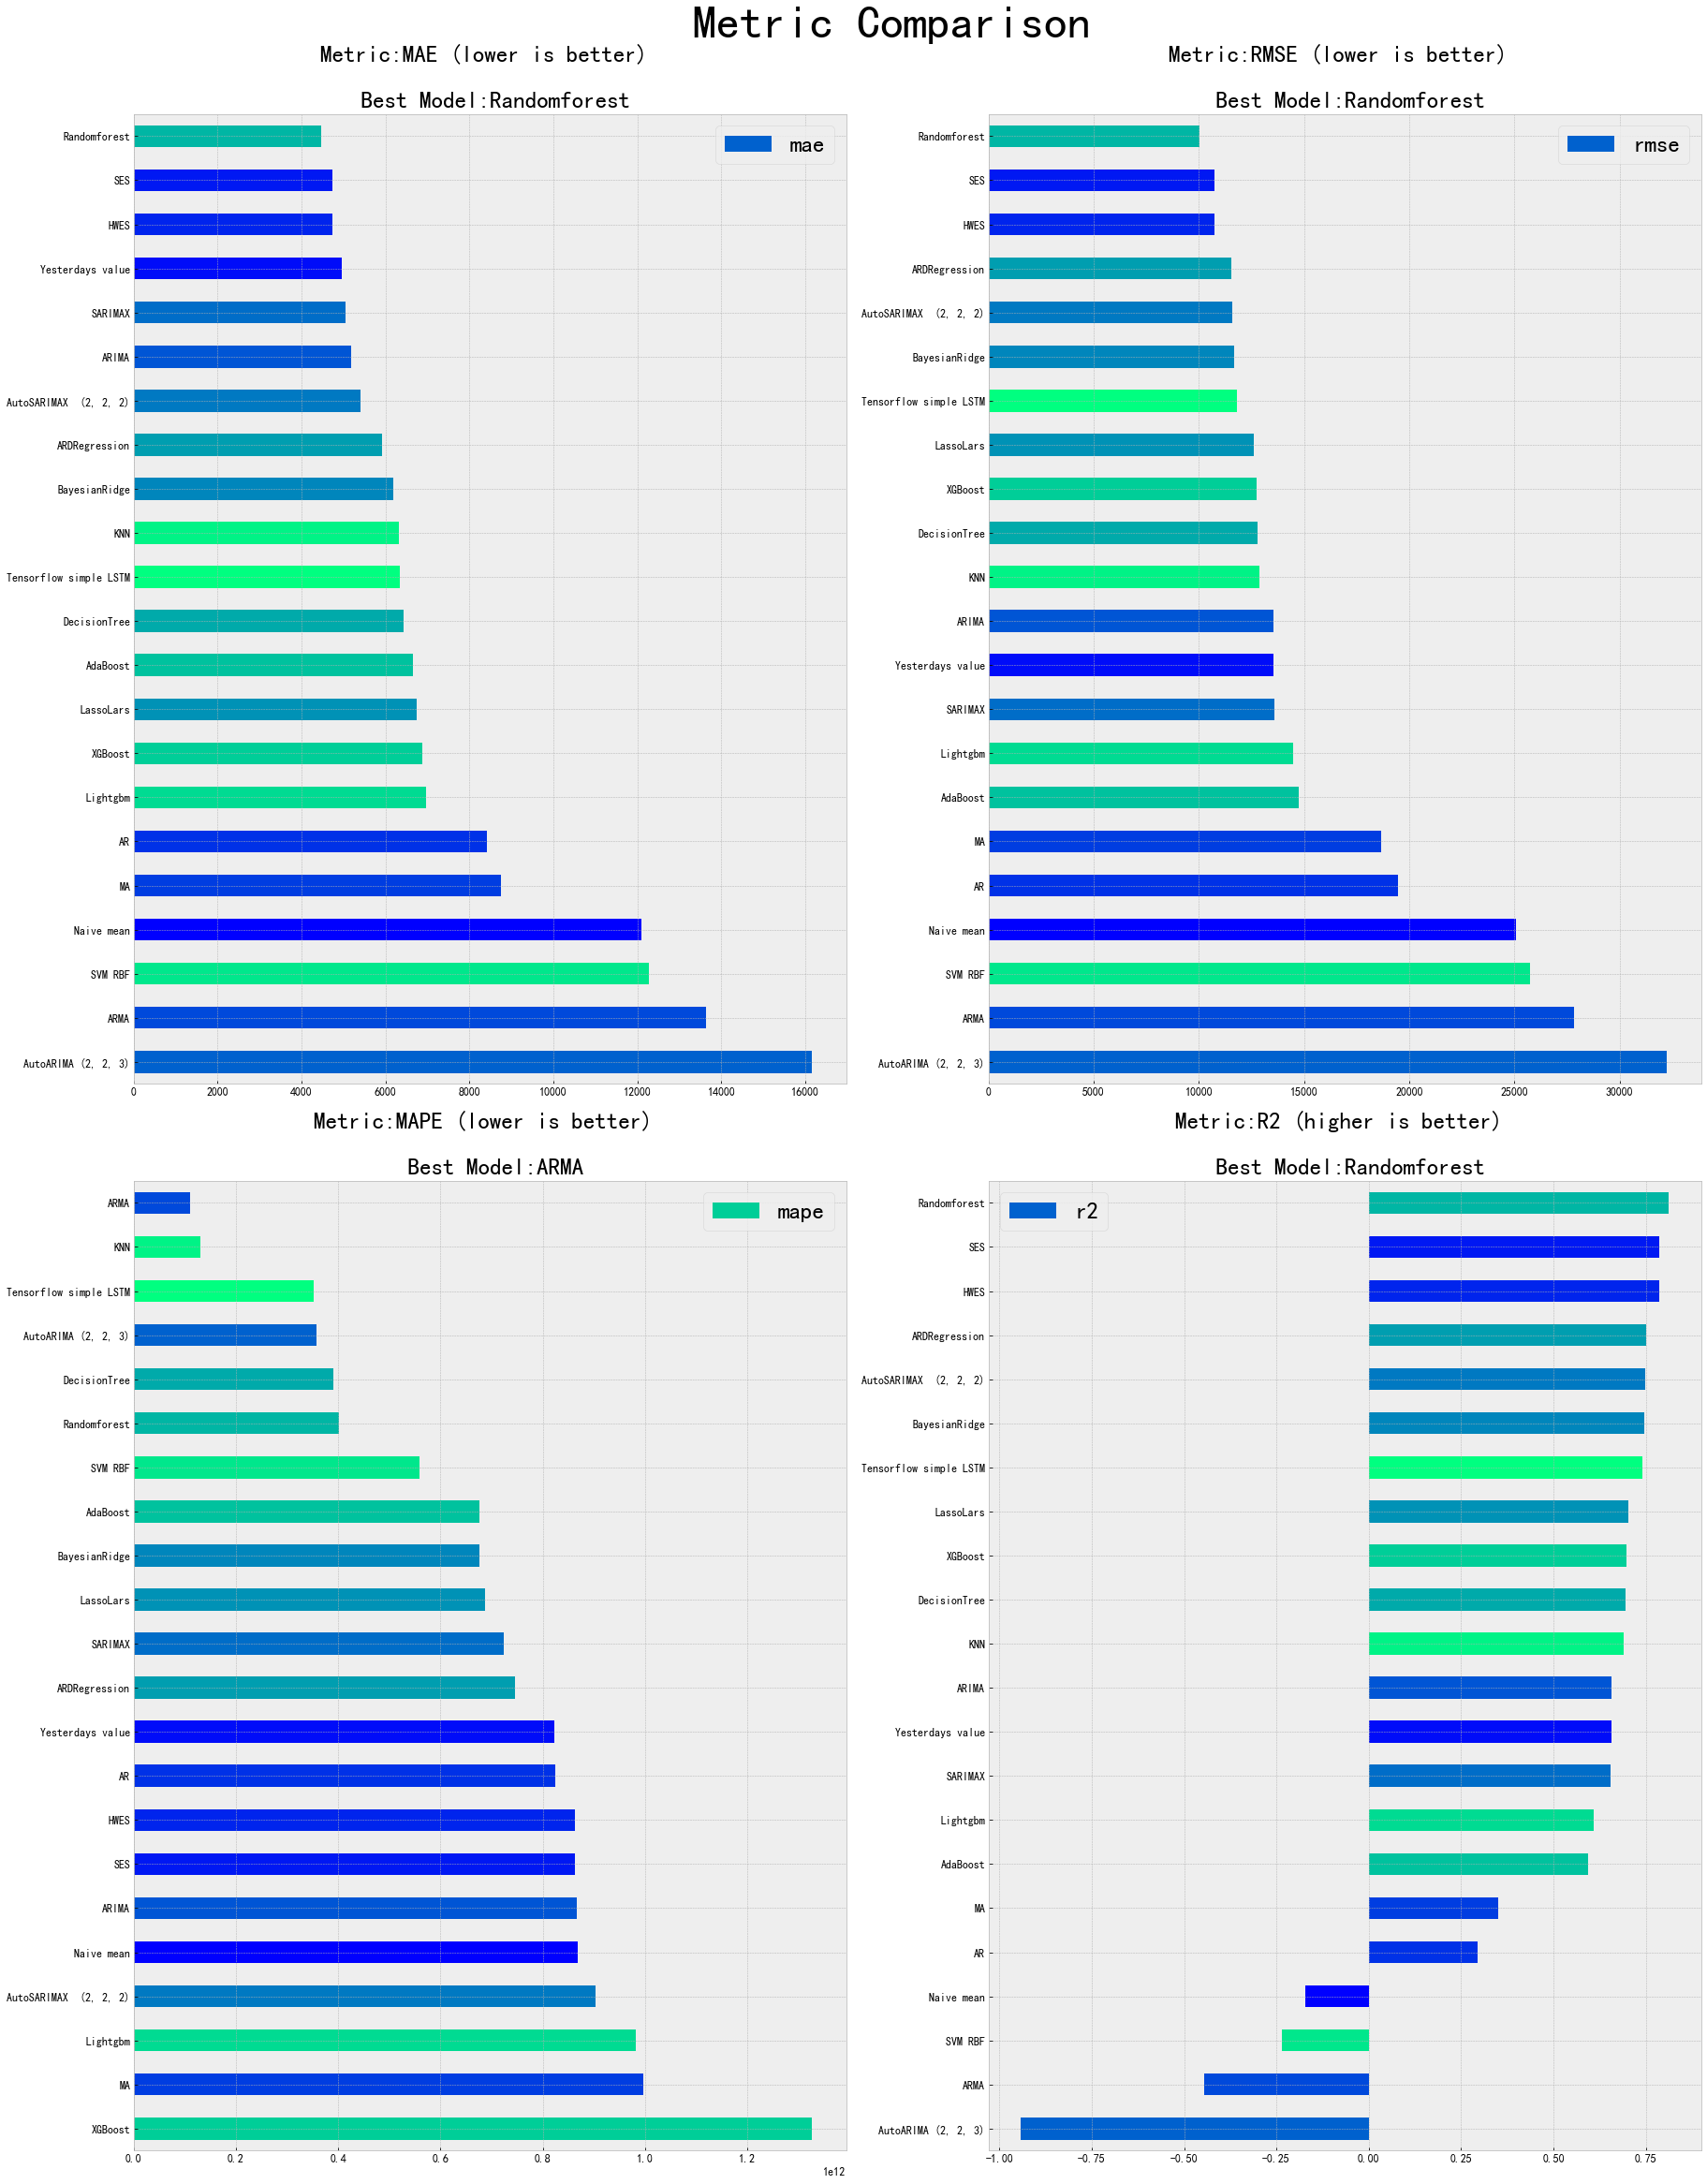

<Figure size 1296x576 with 0 Axes>

In [47]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(2*15, 20*2))
plt.subplots_adjust(hspace=0.1)
plt.suptitle("Metric Comparison", fontsize=50, y = .92)

idx = result_df.index
cols = result_df.columns
pallette = plt.cm.get_cmap("winter", len(idx))
colors = [pallette(x) for x in range(len(idx))]
color_dict = dict(zip(idx, colors))
for metric,ax in zip(result_df.columns, axs.ravel()):
    if metric != 'r2':
        df = result_df[metric].sort_values(ascending=False)
        df.plot(
            ax=ax,
            kind = 'barh',
            colormap="Paired",
            color=[color_dict.get(x, "#ff7f00") for x in df.index],
            label = metric
        )
        ax.set_title(f"Metric:{metric.upper()} (lower is better) \n\n Best Model:{df.index[-1]}",fontsize = 25)

    else:
        df = result_df[metric].sort_values()
        df.plot(
            ax=ax,
            kind = 'barh',
            colormap="Paired",
            color=[color_dict.get(x, "#ff7f00") for x in df.index],
            label = metric
        )
        ax.set_title(f"Metric:{metric.upper()} (higher is better) \n\n Best Model:{df.index[-1]}",fontsize = 25)
        
    ax.legend(fontsize = 25)
    ax.set_xlabel("")
plt.show()
plt.tight_layout()